<h1>PyMuPDF 1.23.0rc1 </h1> 

## <h2>PyMuPDF-Utilities/jupyter-notebooks</h2>

In [1]:
%matplotlib inline
import os
import fitz  # import PyMuPDF
import numpy as np
import matplotlib.pyplot as plt
import unidecode

### 1. Demonstrate the Effect of the MuPDF Dehyphenation Flag




We will demonstrate here the impact of MuPDF's TEXT_DEHYPHENATE flag on extracted text and computed text boundary boxes.

First we import PyMuPDF and make a memory PDF with some hyphenated text.

In [2]:
def show_image(item, title):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: a PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and uses matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    %matplotlib inline

    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set titel of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

In [3]:
text = (
    "This is a longer text with hyphena-\n"
    "ted words. It will be extracted using\n"
    "different flags.\n"
    "This will show, how bit settings influ-\n"
    "ence text bbox computations."
)

doc = fitz.open()  # new empty PDF
page = doc.new_page(width=600,height=400)  # new small-sized page
rect = page.rect + (72, 72, 0, 0)
_ = page.insert_textbox(rect, text, fontsize=24)

In [4]:
#Em portugues

text = (
    "Este é um texto mais longo com hífen-\n"
    "palavras codificadas. Será extraído usando\n"
    "'flags' diferentes.\n"
    "Isso mostrará como as configurações de bits influ-\n"
    "enciam os cálculos de bbox de texto."
)    

doc = fitz.open()  # new empty PDF
page = doc.new_page(width=700,height=400)  # new small-sized page
rect = page.rect + (72, 72, 0, 0)
_ = page.insert_textbox(rect, text, fontsize=24)

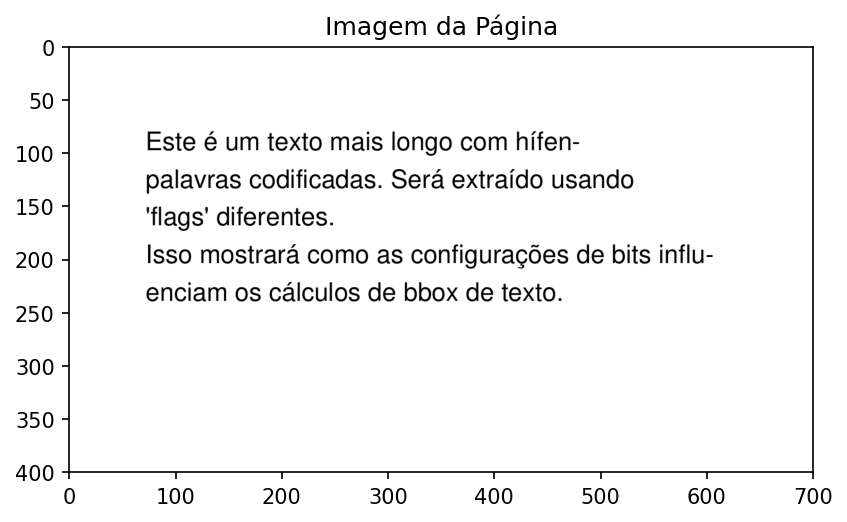

In [5]:

show_image(page, "Imagem da Página")

In [6]:
# using no special flags
print(page.get_text("text", flags=0))

Este é um texto mais longo com hífen-
palavras codificadas. Será extraído usando
'flags' diferentes.
Isso mostrará como as configurações de bits influ-
enciam os cálculos de bbox de texto.



Agora extraia usando a opção de hifenização.

Observe que uma linha será unida à sua sucessora se terminar com um hífen

In [7]:

# using the dehyphenation flag
print(page.get_text("text", flags=fitz.TEXT_DEHYPHENATE))

Este é um texto mais longo com hífenpalavras codificadas. Será extraído usando
'flags' diferentes.
Isso mostrará como as configurações de bits influenciam os cálculos de bbox de texto.



## PDF Journalling

### 2. PDF Journalling Part 1: The Basics

<h3>Introdução</h3>

Os sistemas modernos de gerenciamento de banco de dados (DBMS) incluem recursos de **journalling** diário. Este recurso permite registrar alterações em bancos de dados em arquivos especiais, chamados de diários ou arquivos de log.

Aplicativos de execução longa, atualizando vários bancos de dados logicamente interconectados, não podem ser reiniciados desde o início após falhas, como falhas de energia ou hardware. Isso não implicaria apenas na repetição do trabalho anterior, mas exigiria a restauração prévia de todos os bancos de dados envolvidos - muitas vezes trabalhos de longa execução por si mesmos.

Um aplicativo projetado adequadamente reiniciado no modo de reinicialização de emergência lerá o arquivo de log, procurará o último ponto em que todos os bancos de dados envolvidos estiveram em um estado consistente (o chamado ponto de verificação), reverterá todas as atualizações registradas posteriormente e retomará seu trabalho a partir desse ponto apontar.

O MuPDF oferece suporte a um recurso de registro no diário que disponibiliza os conceitos de DBMS acima para atualização de PDFs.

Os aplicativos que atualizam os bancos de dados agora podem integrar as alterações do PDF em sua lógica de reinicialização do ponto de verificação.

Mas, independentemente de qualquer banco de dados, também é possível colocar atualizações incrementais de um PDF sob o controle do diário de PDF. Juntamente com o arquivo de diário, é possível restabelecer versões anteriores do documento.

Uma nota sobre a terminologia:

    - As atualizações para bancos de dados (SQL) são agrupadas em **"Logical Units of Work" (LUWs)** "Unidades lógicas de trabalho" (LUWs). Existem configurações de banco de dados consistentes no início e no final de um LUW. Escrever um **checkpoint** ponto de verificação, portanto, sempre acontece após o final de um LUW - nunca no meio.

    - No MuPDF, o termo **"operation"** "operação" desempenha o papel de um LUW.

PDF Journalling é um recurso único e inigualável do PyMuPDF e do MuPDF. Ele permite manter um controle avançado sobre as atualizações de documentos PDF, desfazer alterações granulares e uma maneira independente de detectar alterações não autorizadas.

<h3>Part 1: The Basics</h3>

Neste notebook você aprenderá conceitos básicos de diário de PDF usando PyMuPDF:

Como ativar o registro no diário e definir operações

Como fazer e navegar entre as alterações

In [ ]:
"""
Notebook preamble code:
Install and import required packages, define image generation utility.
"""
# Make sure having installed required packages by uncommenting the following lines as required
# !python -m pip install pymupdf
# !python -m pip install matplotlib

import fitz

In [ ]:

if tuple(map(int, fitz.VersionBind.split("."))) < (1, 19, 0):
    raise ValueError("Need PyMuPDF v1.19.0 or higher")

def show_image(item, title):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: a PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and uses matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    %matplotlib inline
    import numpy as np
    import matplotlib.pyplot as plt
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set titel of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))


The actual application code follows here.

We create a new empty PDF and enable journalling for it.

In [ ]:
doc = fitz.open()  # work with an empty PDF
doc.journal_enable()  # enable journalling

After journalling is enabled for a PDF, all updates are being logged, and therefore must be executed within the scope of some operation (called LUW, Logical Unit of Work in DBMS).

We first try an update without having an active operation - just to see what happens:

In [ ]:
try:
    page = doc.new_page()
except Exception as e:
    print(e)

Operations are started and stopped via methods journal_start_op() and journal_stop_op(). Between these statements, any number of updates to the PDF may happen - this is entirely your decision. Undoing an operation will revert all updates within it, so you should plan the design of your operations with due diligence.

In the following, we add a new page to the document and wrap it in an operation.

In [ ]:
doc.journal_start_op("add new page")  # define start of an operation
page = doc.new_page(width=200, height=150)
doc.journal_stop_op()  # define stop of operation

This time it worked: we have a page. Now insert some text lines - each within its own operation, so they can be individually undone.

>The name of an operation is entirely documentary and is left to your discretion

In [ ]:
for i in range(5):
    doc.journal_start_op(f"add line-{i}")
    # insert next line 20 points below previous one
    page.insert_text((50, 40 + 20*i), f"Esta é a linha {i}.")
    doc.journal_stop_op()

<h3>Investigating and Navigating the Journal</h3>

PyMuPDF will append all update activity to an internal log, called "journal" (or sometimes also "history").

There are methods that let us investigate the journal content in various ways. It is possible to navigate up and down inside the journal.

The first information we are interested in: What is our current operation number and what is the total number of operations?

In [ ]:
pos, count = doc.journal_position()  # returns: (current position, operations count)
print(f"Posição do log {pos}, operation count {count}.")

Okay, so this tells us that the current operation was the sixth out of a total number of six. We are positioned at the end of the journal.

How about a list of all operations?

In [ ]:
for i in range(count):  # loop over total number of operations
    print(f"Operation {i}: {doc.journal_op_name(i)}")  # show the operation name

Given our current position: What can we do inside the journal from here on?

The are always two options:

- "undo" - this causes the updates of the current operation to be reverted (undone), and moves us one position backwards in the journal. Use method journal_undo().

- "redo" - this will re-apply the updates of the operation that follows the current one, and makes it the current operation. Use method journal_redo().

As we are currently positioned at the very last operation, there is no "next" operation. Therefore, we get the following result:

In [ ]:
doc.journal_can_do()  # what can we do currently?

Let us nevertheless try to redo something:

In [ ]:
try:
    doc.journal_redo()
except Exception as e:
    print(e)

Only undo activities are possible, currently. Let us try one, but first we look at what is on the page:

In [ ]:
# Display the page image
show_image(page, "Page Content")

Undo the current operation and display the journalling status as above.

In [ ]:
doc.journal_undo()  # undo an operation
doc.journal_position()  # where are we in the journal?

In [ ]:
doc.journal_can_do()  # what can we do now?

So, again as expected:

    1.  Our current position inside the journal is reduced by one - but there are still all six entries in it.

    2. We can do both: undo and redo.
    
The really interesting thing: what happened to the page content?

If all worked fine, we should see only 4 lines of text.

In [ ]:
# Display the page image
show_image(page, "Page Content after Undo")

Good! Last text insertion was reverted.

Let us change our mind again and redo (re-apply) the undone operation. This will re-execute everything contained in the operation following the current one. In other words, our fifth text line should reappear.

In [ ]:
doc.journal_redo()  # redo reverted operation

Confirm that we have five text lines again:

In [ ]:
show_image(page, "Page Content after Redo")

We have learned so far, that undoing and redoing uses the journal like a playbook to change the PDF. These actions do not change the journal itself.

However if, after some undos, new operations are executed, all journal entries will be deleted that follow the current position, and the new operations recorded. Look at the following example.

We undo the last three operations (i.e. delete the last three lines) and then draw a rectangle as a new operation.

In [ ]:
for i in range(3):  # revert last three operations
    doc.journal_undo()
pos, count = doc.journal_position()
print(f"journal position: {pos}")
print(f"operations count: {count} (unchanged)")

In [ ]:
# draw rectangle
doc.journal_start_op("draw rectangle")
page.draw_rect((50, 80, 120, 130), fill=fitz.pdfcolor["blue"])
doc.journal_stop_op()

show_image(page, "Page Image after Drawing an Object")

Also look what happened to the journal:

In [ ]:
pos, count = doc.journal_position()
print(f"journal position: {pos}")
print(f"operations count: {count}")
print("\nList of operations:")
for i in range(count):
    print(f"Operation {i}: {doc.journal_op_name(i)}")

<h3>Wrapping up</h3>

- The journal is kept inside a memory area maintained by MuPDF.
- The journal remains available until the PDF is closed.
- Once enabled, journalling of a PDF cannot be disabled again.
- Journal data can be exported to a file (or file-like object).
- "Undo" reverts the operation at the current position. If current position is the top of the journal, an exception is raised.
- "Redo" re-executes the operation following the current position. If current position is at the end of the journal, an exception is raised.
- Executing operations after an undo removes all journal entries following the current position.

<h3>Conclusion</h3>

In this notebook we have learned the basics about PDF journalling:

- How to enable journalling for a PDF
- How to extract journal information
- How to navigate in the journal and undo or redo operations


<h3>Outlook</h3>

This notebook is the first of a series about PDF journalling. There is the following sequel:

**Part 2:** The notebook will cover journalling updates to an existing PDF, synchronized saving of journal and PDF, and how to enable journalling for a PDF by using a journal file. Please find this notebook here.

### Demonstrating PDF Journalling - Part 2

For an introduction to PDF journalling please see the basic notebook here.

In this notebook we demonstrate how to save a journalled PDF together with the journal such that both can be opened again later, for instance to continue journalled updating, and undoing or redoing operations. You will learn how to:

1. Log changes to an existing file and save the current state.
2. Restart or continue a previously saved journalling session.
3. Use the journalling feature to detect unauthorized changes.

<h3>How to save Journal and PDF for later restart</h3>

We will open an existing PDF and add a new page with some text lines on it. This is much like what we have learned in the previous, introductory notebook.

In [ ]:
file = r".\PyMuPDF_examples\1page.pdf"

In [ ]:
import fitz
from pprint import pprint

if tuple(map(int, fitz.VersionBind.split("."))) < (1, 19, 0):
    raise ValueError("Need PyMuPDF v1.19.0 or higher")

doc = fitz.open(file)  # work with an existing PDF
doc.journal_enable()  # enable journalling for it
doc.journal_start_op("new page")
page = doc.new_page()
doc.journal_stop_op()
# insert 5 text lines, each within its own operation:
for i in range(5):
    doc.journal_start_op("insert-%i" % i)
    page.insert_text((100, 100 + 20*i), "This is line %i." % i)
    doc.journal_stop_op()

We now take a snapshot of the current PDF and its journal. Motivations may e.g. be submitting it to some review, before any redactions are applied, or similar purposes.

In [ ]:
snapname = doc.name.replace(".pdf", "-snap.pdf")
logname = doc.name.replace(".pdf", "-snap.log")

doc.save_snapshot(snapname)
doc.journal_save(logname)
doc.close()

<h3>How to Open a PDF Snapshot and the Associated Journal</h3>


The resulting file, `1page-snap.pdf", is a valid PDF in every aspect: it can be displayed or printed, text can be extracted, etc.

When opening the snapshot PDF and loading the associated journal, any changes applied during journalling can be undone, or more changes can be applied. When finished, take another snapshot and save the journal file again, and so forth.

In [ ]:
doc = fitz.open(snapname)  # open last update state of the PDF
doc.journal_load(logname)  # load the - matchin! - journal file

When the journal file is loaded as above, the following actions take place:

1. Read the content of the journal and confirm that the document matches it.
2. If successful, journalling is automatically enabled, and current journal position is established.

If the journal does not match the PDF, an exception is raised. This can be used to detect changes to a PDF - see below.

We now make a few checks to see what we have got:

In [ ]:
print(f"Snapshot PDF '{snapname}' has the following update status:")
print()
pos, count = doc.journal_position()
print(f"Journal position {pos}, operations count {count}.")
for i in range(count):
    print("Operation %i: '%s'" % (i, doc.journal_op_name(i)))

actions = doc.journal_can_do()
print()
print("Possible actions:")
print("    undo: '%s'" % actions["undo"])
print("    redo: '%s'" % actions["redo"])

<h3>How to Use Journalling for Detecting Unauthorized Updates</h3>

As a side benefit, the journalling feature can be used to confirm that a PDF still is the expected version, or to detect unauthorized changes.

Follow this approach to store the current PDF state:

In [ ]:
file_input = r".\PyMuPDF_examples\input.pdf"

In [ ]:
doc.name

In [ ]:
# File name
file_save = doc.name + "-status.log"

In [ ]:
file_save

In [ ]:

 
# File location
location = ".\PyMuPDF_examples"
 
# Path
path = os.path.join(location, file_save)
 
# Remove the file
# 'file.txt'
#os.remove(path)

In [ ]:
doc = fitz.open(file_input)
doc.journal_enable()
doc.journal_save(file_save)  # chhoose a suitable journal filename
doc.close()

Even if no updates are happening, the journal as a minimum will contain a so-called Fingerprint (hash value) that can be used to confirm the PDF's identity. This is independent from any password protection, the file name, or PDF-internal /ID field values. In our case, the journal will look like this:

When processing the PDF in some downstream application, perform the following check:

In [ ]:
doc = fitz.open(file_input)
try:
    doc.journal_load(doc.name + "-status.log")  # load previously saved journal
    print(f"Confirming: file '{doc.name}' is in expected state.")
    doc.close()  # to switch off journalling
    doc = fitz.open(doc.name)
except Exception as e:
    print (f"Unauthorized changes to file '{doc.name}' detected.")
    raise
print(f"Journalling enabled: {doc.journal_is_enabled()}.")  # confirming: journalling disabled

<h3>Conclusion</h3>

In this notebook we have learned:

How to log updates to an existing PDF and save the current state
How to resume a previous journalling session and continue updating
How to confirm the expected state of a PDF in downstream applications.

## Algebra for Geometry Objects in PyMuPDF

In [ ]:
import fitz
assert tuple(map(int, fitz.VersionBind.split("."))) >= (1,19,6)

<h3>Overview</h3>

PyMuPDF supports the 2-dimensional geometry objects as defined in MuPDF, and in the PDF specifications. Geometry objects are <B> Point, IRect, Rect, Quad and Matrix </B>. They all represent more or less what their names suggest them to be: they pertain to objects in plane geometry, mostly according to the requirements and terminology of PDF specification.

    - A Point is represented by a pair of floats: fitz.Point(x, y). In PyMuPDF they can be treated as 2-dimensional vectors, including component-wise addition and multiplication by numbers and matrices.

    - Rect and IRect are specialized subsets of general rectangles: their edges always are parallel to the x- and the y-axis. While a Rect may be defined by float numbers, an IRect has integer coordinates. Further classifications include valid, empty or infinite, which imply certain behaviors and possibilities. Like points, rectangles can also be added to each other and can be multiplied by numbers and matrices. Because of their their special make-up, rectangles can be defined by just 2 points (or correspondingly 4 floats), that are diagonally opposite. By convention, (Py-) MuPDF uses the top-left and the bottom-right points (in this sequence) for this: fitz.Rect(x0, y0, x1, y1). Using a different sequence, or the other two points leads to invalid rectangles.

    -  A Quad is a quadrilateral or tetragon. It is defined by its 4 corner points in the mandatory sequence upper-left (ul), upper-right (ur), lower-left (ll), lower-right (lr). Quads are much less frequently used than rectangles, but they do play an important role, e.g. for non-horizontal text.

    - A Matrix represents a mapping (or "transformation") within objects of any of the above classes. Every geometry object above has method transform(): OBJ.transform(matrix) maps OBJ (one of Point, Rect, IRect, Quad) to a new object of the same type, which then replaces OBJ. Matrices also support component-wise addition and mutiplication with each other via matrix method concat(). A matrix is represented by 6 floats fitz.Matrix(a, b, c, d, e, f) arranged in a special structure of a row-major 3 x 3 matrix:

        / a b 0 \
        | c d 0 |
        \ e f 1 /

    - The above objects are implemented as Python sequences, which makes it possible to access and modify their components also via index.

    - The better part of functions and methods however only needs the underlying sequence of geometry objects. PyMuPDF therefore defines the notions "point-like", "rect-like", "quad-like" and "matrix-like" to indicate that a numerical sequence (tuple, list, array, ndarray ...) with the right length is sufficient.



<h3>Algebraic Operations</h3>

PyMuPDF defines unary and binary operators that allow handling geometry objects comfortably and intuitively.

<h3>Unary Operators</h3>

PyMuPDF defines a number of unary operators, i.e. involving only one geometry object. The result always is either a bool, a float, or a new object of the same type as the operand.

abs() - (float) the Euclidean norm for Point and Matrix, and the area of Rect and IRect rectangles. For a Quad the product of its width and height.
norm() - (float) the Euclidean norm.
bool() - (bool) is False exactly if all components are zero.
hash() - implemented as hash(tuple(OBJ)).
~m - (Matrix) the inverse of matrix m. If not invertible, the matrix with all zeroes is returned.
+OBJ, -OBJ - copy of the original. Negated components if "-" is used.
Binary Operators
Binary operators involve two objects. The first operand determines the object type.

Addition, Subtraction
Use + and - to add / subtract objects of the same class. This works component-wise. The second operand must be like the first one - i.e. just a numerical sequence. The second operand may also be just a number, if all components should be modified with the same value. The result is always a new object. The following example equalities apply analogously also to Rect, IRect, Quad and Matrix objects:

In [ ]:
import fitz
(
 fitz.Point(1, 2) + fitz.Point(1, 1)
 == fitz.Point(1, 2) + (1, 1)
 == fitz.Point(1, 2) + 1
 == fitz.Point(2, 3)
)

Multiplication, Division

Use * and / to multiply points, rectangles, quads or matrices with a number or a matrix-like. For division, the number or matrix-like must obviously be invertible. The result is a new object.

Multiplication of matrices is not commutative - in the general case we have m * n ≠ n * m. There exist non-zero matrices which are not invertible.

There is a neutral Matrix under multiplication - Identity - such that for every matrix m we have m * fitz.Identity == fitz.Identity * m == m.

In [ ]:
import fitz
fitz.Point(2, 4) / 2 == fitz.Point(1, 2)
(
    fitz.Point(1, 2) * fitz.Matrix(1, 2, 3, 4, 5, 6) == 
    fitz.Point(1, 2) * (1, 2, 3, 4, 5, 6)
)
(
    fitz.Point(1, 2) / fitz.Matrix(1, 2, 3, 4, 5, 6) ==
    fitz.Point(1, 2) / (1, 2, 3, 4, 5, 6)
)

Other Binary Operators


Checking whether geometry objects are equal is specialized to equality of their components.

Checking whether objects are contained in a rectangle or quad is fully supported.

Rectangles have special operators that allow building unions or intersections.

Relevant binary operators also support in-place notation.

Equality checks: geometry objects (and, resp., -likes) are regarded equal if bool(a - b) == False, where b may be a-like. This means that fitz.Point(2, 4) == (2, 4) returns True! But of course (2, 4) != fitz.Point(2, 4)!
Containment checks: Classes Rect, IRect and Quad have method OBJ.contains(x), which checks whether x is contained in OBJ, returning True or False. Object x may be any of point-like, rect-like or quad-like. The Python syntax x in OBJ is likewise supported.
&, |: Rectangles (only) support unions and intersections. The expression rect | x ("union") delivers the smallest rectangle containing rectangle rect and rect-like / point-like x. The expression rect & x ("intersection") is the largest rectangle contained in both, rectangle rect and rect-like x. The following snippet creates the smallest rectangle that covers all points in a list:

In [ ]:
import fitz
points = []  # a list of point-likes
for i in range(5):
    for j in range(3):
        points.append((i, j))
rect = fitz.EMPTY_RECT()  # start with the standard empty rectangle
for point in points:
    rect |= point  # in-place binary operators are supported!
print(rect)

As mentioned above, binary operators support in-place notation and allow elegant formulations like rect *= (1, 2, 3, 4, 5, 6).

More examples:

Middle point on the line connecting points p1 and p2: mp = (p1 + p2) / 2.
Top-left quarter rectangle of a page: rect = page.rect / 2.
Shift a rectangle to the right by 5 units: rect += (5, 0, 5, 0).
Enlarge a rectangle in every direction: rect += (-5, -5, 5, 5).
Compute page sub-rectangle, leaving a 1-inch border: rect = page.rect + (72, 72, -72, -72).
Setting Brackets
Objects of the same class are mathematical groups with respect to addition and thus allow arbitrary setting of brackets. I.e. the following is always true if a, b and c are all points, rectangles, quads or matrices:

## Example: Detect and Repair Unrecognized Characters

With the OCR capability introduced in its version 1.19.0, PyMuPDF is capable of recognizing characters that remain illegible with normal text extraction. The following script reads a document page via get_text("dict"). If encountering unrecogized unicodes (which are returned as 0xFFFD), it OCRs the respective text span and uses that text instead. While a similar approach was always available with package easyocr or invocation of an installed Tesseract (via a subprocess), the new solution is not only cleaner and works with the included batteries, but also more than 10 times faster.

In [8]:
from PIL import Image

import pytesseract

# If you don't have tesseract executable in your PATH, include the following:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
# Example tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

In [ ]:
tessdata_dir_config = '--tessdata-dir "/home/dani-boy/miniconda3/envs/tables-detr/share/tessdata/" --user-patterns "novo_modelo/modelos/user-patterns2.txt" --dpi 600 --oem 3 --psm 6

In [9]:
# If you don't have tesseract executable in your PATH, include the following:
tessdata_dir_config = '--tessdata-dir "/home/dani-boy/miniconda3/envs/tables-detr/share/tessdata/" --user-patterns "novo_modelo/modelos/user-patterns2.txt" --dpi 600 --oem 3 --psm 6'

In [3]:
# If you don't have tesseract executable in your PATH, include the following:
tessdata_dir_config = '--tessdata-dir "C:\\Program Files\\Tesseract-OCR\\tessdata"'

In [10]:
"""
Demo script using Mupdf OCR.

Extract text of a page and interpret unrecognized characters using OCR.
MuPDF codes unrecognizable characters as 0xFFFD = 65533.
Extraction option is "dict", which delivers contiguous text pieces within one
line, that have the same font properties (color, fontsize, etc.). Together with
the language parameter, this helps Tesseract finding the correct character.

The basic approach is to only invoke OCR, if the span text contains at least
one chr(65533) character.

--------------
This demo will OCR only text, that is known to already be text. This means, it
does not look at parts of a page containing images or text encoded as drawings.
--------------

Dependencies:
PyMuPDF v1.19.0
"""
import fitz
import time

In [11]:
assert tuple(map(int, fitz.VersionBind.split("."))) >= (1, 19, 0), "Need PyMuPDF v1.19.*"
assert fitz.TESSDATA_PREFIX, "Need Tesseract's tessdata for OCR function"
DPI = 400  # high resolution
OCR_TIME = 0
PIX_TIME = 0

In [12]:
def get_tessocr(page, span):
    """Return OCR-ed span text using Tesseract.

    Args:
        page: fitz.Page
        span: a span from get_text("dict")
    Returns:
        The OCR-ed text of the bbox.
    """
    global OCR_TIME, PIX_TIME, ZOOM
    # Step 1: Make a high-resolution image of the span bbox.
    t0 = time.perf_counter()
    pix = page.get_pixmap(dpi=DPI, clip=span["bbox"])
    t1 = time.perf_counter()

    # Step 2: OCR the bbox. Delivers a 1-page PDF in memory
    ocrpdf = fitz.open("pdf", pix.pdfocr_tobytes(language='por',tessdata="C:\\Program Files\\Tesseract-OCR\\tessdata"))
    ocrpage = ocrpdf[0]
    new_text = ocrpage.get_text()  # extract OCR-ed text
    t2 = time.perf_counter()
    OCR_TIME += t2 - t1
    PIX_TIME += t1 - t0

    # Tesseract ignores leading spaces, hence some corrections
    old_text = span["text"]  # the original span text
    # compute number of leading spaces
    lblanks = len(old_text) - len(old_text.lstrip())

    # prefix OCRed text with this many spaces
    new_text = " " * lblanks + new_text

    # walk through old text replacing illegible chars with the OCR result
    return_string = "%"  # we will return this string
    for i in range(len(old_text)):
        if old_text[i] != chr(0xfffd):  # this char was no problem
            return_string += old_text[i]
        else:
            return_string += new_text[i]  # else take recognized char
    print("before OCR: '%s'" % old_text)
    print(" after OCR: '%s'" % return_string)
    return return_string

In [13]:
pdf_file = "pipeline_extracao_documentos/2_documentos_para_extracao/21_aguardando_processamento/Batch_20/fwdnotasfaltantesnosistemadeemissoim20734_106187/Doria Marinho 0301 Ultrascan.pdf"

In [14]:

doc = fitz.open(pdf_file)

In [16]:
ocr_count = 0
for page in doc:
    blocks = page.get_text("dict", flags=0)["blocks"]
    for b in blocks:
        for l in b["lines"]:
            for s in l["spans"]:
                text = s["text"]
                if chr(0x0024) in text:  # invalid characters encountered!    0xfffd
                    # invoke OCR
                    ocr_count += 1
                    new_text = get_tessocr(page, s)

print("-------------------------")
print("OCR invocations: %i." % ocr_count)
# print(
#     "Pixmap time: %g (avg %g) seconds."
#     % (round(PIX_TIME, 5), round(PIX_TIME / ocr_count, 5))
# )
# print(
#     "OCR time: %g (avg %g) seconds."
#     % (round(OCR_TIME, 5), round(OCR_TIME / ocr_count, 5))
# )

-------------------------
OCR invocations: 0.


https://stackoverflow.com/questions/61835048/runtimeerror-failed-to-init-api-possibly-an-invalid-tessdata-path-c-users-hp

You can also pass it in to PyTessBaseAPI as per the docs: